<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Neural-Machine-Translation-NMT-with-attention/blob/main/20230113_MSc_DA_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system with an attention model.

This is an **individual assignment** and usual rules for plagiarism apply! With this you agree that: "In submitting this work I confirm that it is entirely my own. I acknowledge that I may be invited to online interview if there is any concern in relation to the integrity of my exam." 

**Write comments and documentation.**



## Mounting Drive and setting paths

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Changing the directory on file to access the files
%cd /content/drive/MyDrive/Colab Notebooks/NUIG/NLP/Assignment 2

/content/drive/MyDrive/Colab Notebooks/NUIG/NLP/Assignment 2


## Section 1- Data Collection and Preprocessing 


---


In [3]:
# Loading necessary libraries

import pandas as pd
import numpy as np
import keras
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model
from numpy import array
from numpy import asarray
from numpy import zeros
import nltk
from nltk import bigrams, trigrams, ngrams
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Activation, dot, concatenate, TimeDistributed
import io

**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from the OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train, development and test set
*  Print 100th sentence in original script for source and target language


---
Language Selected: **English - Spanish**

Source: https://opus.nlpl.eu/ 

**Corpus: Tatoeba v2021-03-10 -- en(English) - es(Spanish)** 

NOTE: Downloaded zip file from moses link -> extracted files and renamed them to **Tatoeba - english.txt** and **Tatoeba - spanish.txt** 

---

In [4]:
# SOURCE Language : list of lines
with open("English - Dutch/english.txt" , 'r', encoding='utf-8') as english_file:
  source = english_file.read().split('\n')         

# TARGET Language : list of lines
with open("English - Dutch/dutch.txt" , 'r', encoding='utf-8') as dutch_file:
  target = dutch_file.read().split('\n')         

In [5]:
# Filter source sentences which have max length < 10

source_lines = []            # The SOURCE sentence at the index 
target_lines = []            # The TARGET sentence at the index

# loop to append index'es 
for line in range(len(source)):

  if(len(source[line].split()) > 0 and len(source[line].split()) < 10 and len(target[line].split()) > 0 and len(target[line].split()) < 10):
    source_lines.append(source[line])
    target_lines.append(target[line])
    
    # index.append(line)
    if(len(source_lines) == 10000):    # Break if 10K sentences are acquired
      break 

In [6]:
# Original number of sentences in SOURCE and TARGET files 
print("Source (English): Total Number of Sentences:", len(source))                        # 302437 sentences
print("Target (Dutch): Total Number of Sentences:", len(target))                        # 302437 sentences

print("\nSource (English): Filtered Number of Sentences:", len(source_lines))             # 10000 sentences                       
print("Target (Dutch): Filtered Number of Sentences:", len(target_lines))               # 10000 sentences

# Print 100th sentence in original SOURCE and TARGET files
print("\nSource (English): 100th Sentence: ", source_lines[99])
print("Target (Dutch): 100th Sentence: ", target_lines[99])

Source (English): Total Number of Sentences: 74058
Target (Dutch): Total Number of Sentences: 74058

Source (English): Filtered Number of Sentences: 10000
Target (Dutch): Filtered Number of Sentences: 10000

Source (English): 100th Sentence:  Thanks for your explanation. 
Target (Dutch): 100th Sentence:  Bedankt voor de uitleg. 


**NOTE**: I have performed Train-Test-validation spilt in next section after all the text pre-processing

---
**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the pre-processing step of the text.
* Print the last 5 sentences of the preprocessed text.
* Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language
  * Source Vocabulary
  * Target Vocabulary





In [7]:
# PREPROCESSING - function to remove punctuation characters and digits '''"!-+.?$%,:;_*/\\^|~`{}#@&()='''
def punctuations(sentence):
  punct_chars =  '''!"@€#$%&'()*+,-./:;<=>?@[\]^_`{|}~„''' + string.digits

  # remove punctuation from the string
  no_punct = ""
  for char in sentence:
    if char not in punct_chars:
      no_punct = no_punct + char
  
  return(no_punct)

In [8]:
# Defining the SOURCE & TARGET sets to store the vocabulary of complete dataset
source_vocab = set()
target_vocab = set()

# Pre-processing the SOURCE and TARGET sentences for the original lines
# Converting to lowercase and removing leading and trailing whitespaces
source_lines = [line.lower().strip() for line in source_lines]
target_lines = [line.lower().strip() for line in target_lines]

# removing punctuations
source_lines = [punctuations(line) for line in source_lines]
target_lines = [punctuations(line) for line in target_lines]

# Adding '<bof>' to denote beginning of sentence and '<eos>' to denote the end of the sentence to each target line.
target_lines = ['<bof> ' + target + ' <eos>' for target in target_lines]

# creating the vocab set for SOURCE
for line in source_lines:
  words_per_line = line.split()
  for word in words_per_line:
    if word not in source_vocab:
      source_vocab.add(word)

# creating the vocab set for TARGET
for line in target_lines:
  words_per_line = line.split()
  for word in words_per_line:
    if word not in target_vocab:
      target_vocab.add(word)

In [9]:
# Last 5 sentences after preprocessing
# SOURCE lines
print("Last 5 sentences from preprocessed SOURCE - English")
i = 4
for line in source_lines[-5:]:
  print("sentence ", len(source_lines)-i, ": ", line)
  i-=1

# TARGET lines
print("\nLast 5 sentences from preprocessed TARGET - Dutch")
i = 4
for line in target_lines[-5:]:
  print("sentence ", len(target_lines)-i, ": ", line)
  i-=1 

Last 5 sentences from preprocessed SOURCE - English
sentence  9996 :  im from tokyo
sentence  9997 :  i took it for granted that she would come
sentence  9998 :  i tried to escape
sentence  9999 :  i am reading a book about animals
sentence  10000 :  i went to the zoo

Last 5 sentences from preprocessed TARGET - Dutch
sentence  9996 :  <bof> ik kom uit tokio <eos>
sentence  9997 :  <bof> voor mij was het vanzelfsprekend dat zij zou komen <eos>
sentence  9998 :  <bof> ik probeerde te ontsnappen <eos>
sentence  9999 :  <bof> ik lees een boek over dieren <eos>
sentence  10000 :  <bof> ik ging naar de dierentuin <eos>


In [10]:
# Statistics of the dataset -- Reference Lab 8
# SOURCE and TARGET vocabulary as sorted list 
source_vocab = sorted(list(source_vocab))            
target_vocab = sorted(list(target_vocab))

# Number of Encoder and Decoder tokens
len_source_vocab = len(source_vocab)+1                # 2613 tokens
len_target_vocab = len(target_vocab)+1                # 3280 tokens

# Max sequence length for Encoder and Decoder
max_seq_len_source = max([len(line.split()) for line in source_lines])      # 18
max_seq_len_target = max([len(line.split()) for line in target_lines])      # 30

print('Number of samples\t\t\t:', len(source_lines))
print('Number of unique SOURCE language tokens\t:', len_source_vocab)
print('Number of unique TARGET language tokens\t:', len_target_vocab)
print('Max sequence length of SOURCE language\t:', max_seq_len_source)
print('Max sequence length of TARGET language\t:', max_seq_len_target)
print("Source Vocabulary\t\t\t:",source_vocab)
print("Target Vocabulary\t\t\t:",target_vocab)

Number of samples			: 10000
Number of unique SOURCE language tokens	: 4499
Number of unique TARGET language tokens	: 5685
Max sequence length of SOURCE language	: 9
Max sequence length of TARGET language	: 11
Source Vocabulary			: ['a', 'abandon', 'abbreviation', 'abc', 'able', 'abnormal', 'abnormality', 'aboard', 'abolish', 'abolished', 'abortions', 'abound', 'abounds', 'about', 'above', 'abraham', 'abroad', 'absence', 'absent', 'absented', 'absolutely', 'absolves', 'absorbs', 'absurd', 'abused', 'accelerate', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'accessible', 'accident', 'accidents', 'accompanied', 'accompany', 'accord', 'according', 'account', 'accounts', 'accurate', 'accused', 'accustomed', 'ache', 'achieved', 'acid', 'acquaintance', 'acquainted', 'acquired', 'across', 'act', 'acted', 'action', 'actions', 'active', 'activity', 'actor', 'actress', 'acts', 'actually', 'adapted', 'add', 'addict', 'addition', 'address', 'adds', 'adequate', 'adhered', 'adjacent', '

In [11]:
# Splitting the data into Train(90%) and tests(10%)
# will split the 90% Train into --> train(80%) and validation(10%) in model.fit()
X_train, X_test, y_train, y_test = train_test_split(source_lines, target_lines, test_size = 0.1,  random_state = 42)

# print(len(X_train), len(X_test)) --- (9000, 1000)

**Task 3 (15 marks)** 

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained embeddings, for example GloVe or fastText (10 marks) (https://nlp.stanford.edu/projects/glove/ , https://fasttext.cc/docs/en/english-vectors.html)
* Print the first line of the embeddings (see below) 

In [12]:
# Assigning each word/token an integer value for both SOURCE and TARGET 
source_vocab_index = dict([(word,i+1) for i, word in enumerate(source_vocab)])                  # 2613 tokens 
target_vocab_index = dict([(word,i+1) for i, word in enumerate(target_vocab)])                  # 3280 tokens 

Tried using various fastText word-embedding(smallest: "wiki-news-300d-1M.vec.zip") but the session always crashed after using all the available RAM on google colab.

Thus using GloVe word-embedding --- Reference from Lab 2

In [13]:
# path_to_fast_text_file = "/content/drive/MyDrive/Word Embeddings/FastText/wiki-news-300d-1M.vec"

# ftxt_embeddings = {}

# fin = io.open(path_to_fast_text_file, 'r', encoding='utf-8', newline='\n', errors='ignore')
# n, d = map(int, fin.readline().split())

# for line in fin:
#   tokens = line.rstrip().split(' ')
#   ftxt_embeddings[tokens[0]] = list(map(float, tokens[1:]))

In [14]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [15]:
path_to_glove_file = "/content/drive/MyDrive/Word Embeddings/GloVe/glove.6B.300d.txt"

glove_embeddings = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

In [16]:
# Creating our own word-embedding from the pre-trained GloVe embedding

# Embedding Shape - 100 - because the pretrained model selected has 300 dimensions
# len(glove_embeddings['the'])
embedding_shape = 300
# source_embedding shape : (2580, 100) --- (source_tokens, vector dimensions)
source_embedding = zeros((len(source_vocab_index)+1, embedding_shape))

# for every source token present in GloVe embedding
# extract the vector and assign it to our own word-embedding
for word, index in source_vocab_index.items():
  try:
    vector = glove_embeddings[word]
    source_embedding[index] = vector
  except:
    continue

In [17]:
# Printing First line of embedding
print(source_embedding[1])

[-2.97120005e-01  9.40489992e-02 -9.66619998e-02 -3.44000012e-01
 -1.84829995e-01 -1.23290002e-01 -1.16559997e-01 -9.96920019e-02
  1.72649994e-01 -1.63859999e+00  1.02200001e-01  3.42530012e-02
 -2.42129996e-01  4.82119992e-02  2.70599991e-01  3.59959990e-01
 -4.07790005e-01  2.37849995e-01  2.42449999e-01 -3.11069995e-01
 -4.82870013e-01  2.61009991e-01  1.18780002e-01  5.10110021e-01
 -3.11150014e-01 -3.70050013e-01  1.16250001e-01 -4.20610011e-01
 -3.43910009e-02  1.18089996e-01 -4.89549994e-01  3.36930007e-01
 -1.33870006e-01  3.49240005e-01 -8.37000012e-01  5.66910028e-01
 -5.36700010e-01  3.85589987e-01 -2.89750010e-01  6.24700010e-01
  4.84890014e-01  3.63570005e-01  3.58680010e-01  8.95970017e-02
 -5.53600006e-02  1.12180002e-01  2.56830007e-01 -7.67130032e-02
 -1.94220006e-01 -1.82429999e-01 -3.28410000e-01  6.40140027e-02
  5.19709997e-02  2.04940006e-01  9.99479964e-02 -2.71600008e-01
 -4.64159995e-01  1.09660000e-01  3.86059999e-01 -3.84359986e-01
 -3.87719989e-01  2.82959

## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [18]:
# encoder input data : each source line (10K) is considered having sentence length = having max sentence length(18) 
# which is filled with 1-hot encoded tokens(2580)
encoder_input_data   = np.zeros((len(X_train), max_seq_len_source), dtype='float32')

# decoder input data : each target line (10K) is considered having sentence length = having max sentence length(30) 
# which is filled with 1-hot encoded tokens(4650)
decoder_input_data   = np.zeros((len(y_train), max_seq_len_target), dtype='float32')

# decoder target data : each target line (10K) is considered having sentence length = having max sentence length(30) 
# which is filled with 1-hot encoded tokens(4650)
decoder_target_data  = np.zeros((len(y_train), max_seq_len_target, len_target_vocab), dtype='float32')

In [19]:
# One- hot encoding
for line_index, (source_indv_line, target_indv_line) in enumerate(zip(X_train, y_train)):
  for token_index, token in enumerate(source_indv_line.split()):
    encoder_input_data[line_index, token_index] = source_vocab_index[token]

  for token_index, token in enumerate(target_indv_line.split()):
    decoder_input_data[line_index, token_index] = target_vocab_index[token]

    if(token_index > 0):
      decoder_target_data[line_index, token_index - 1, target_vocab_index[token]] = 1

print("Encoder_input_data shape: ", encoder_input_data.shape, "\nSentence: ", X_train[0], "\nsample: ", encoder_input_data[0])
print("\nDecoder_input_data shape: ", decoder_input_data.shape, "\nSentence: ", y_train[0], "\nsample: ", decoder_input_data[0])
print("\nDecoder_output_data shape: ", decoder_target_data.shape, ",\nsample: ", decoder_target_data[0])

Encoder_input_data shape:  (9000, 9) 
Sentence:  the foreigner didnt know japanese at all 
sample:  [3987. 1555. 1089. 2189. 2097.  259.  122.    0.    0.]

Decoder_input_data shape:  (9000, 11) 
Sentence:  <bof> de buitenlander kende helemaal geen japans <eos> 
sample:  [1.000e+00 9.070e+02 7.420e+02 2.286e+03 1.882e+03 1.431e+03 2.158e+03
 2.000e+00 0.000e+00 0.000e+00 0.000e+00]

Decoder_output_data shape:  (9000, 11, 5685) ,
sample:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Training Seq2Seq model

In [20]:
epochs          = 100
batch_size      = 396
latent_dim      = 1024
embedding_shape = 300

In [21]:
# Defining Encoder Architecture , trainable = False
encoder_input    = Input(shape = (max_seq_len_source,), name = 'Encoder_input')
embedded_encoder = Embedding(len_source_vocab, embedding_shape, weights=[source_embedding])(encoder_input)
encoder_output, state_h, state_c = LSTM(latent_dim, return_state=True)(embedded_encoder)
encoder_state = [state_h,state_c]

In [22]:
# Defining Decoder Architecture
decoder_input    = Input(shape = (max_seq_len_target,), name = 'Decoder_input')
embedded_decoder = Embedding(len_target_vocab, latent_dim)(decoder_input)
decoder_output, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(embedded_decoder, initial_state = encoder_state)

# Using Softmax activation
decoder_dense = Dense(len_target_vocab, activation='softmax', name = 'Decoder_Dense')
decoder_output = decoder_dense(decoder_output)

In [23]:
model = Model(inputs = [encoder_input, decoder_input], outputs = decoder_output, name = 'Original_NMT_model')
model.summary()

Model: "Original_NMT_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 9)]          0                                            
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 300)       1349700     Encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 1024)     5821440     Decoder_input[0][0]              
_________________________________________________________________________________

In [24]:
# for k,v in model._get_trainable_state().items():
#     print(k,v)

In [25]:
model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics=['accuracy'])

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')

# Fitting the model
model_history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                          batch_size = batch_size , epochs = epochs, validation_split=0.12,
                          callbacks=[reduce_lr, early_stop])

model.save('English - Dutch/NMT_seq2seq_no_Attention.h5')

Epoch 1/100
20/20 [==============================] - 21s 873ms/step - loss: 4.0943 - accuracy: 0.0826 - val_loss: 3.4863 - val_accuracy: 0.1192
Epoch 2/100
20/20 [==============================] - 16s 789ms/step - loss: 3.3962 - accuracy: 0.1220 - val_loss: 3.4200 - val_accuracy: 0.1375
Epoch 3/100
20/20 [==============================] - 16s 798ms/step - loss: 3.2787 - accuracy: 0.1376 - val_loss: 3.4401 - val_accuracy: 0.1364
Epoch 4/100
20/20 [==============================] - 16s 793ms/step - loss: 3.2077 - accuracy: 0.1426 - val_loss: 3.2651 - val_accuracy: 0.1527
Epoch 5/100
20/20 [==============================] - 16s 794ms/step - loss: 3.0437 - accuracy: 0.1575 - val_loss: 3.2067 - val_accuracy: 0.1613
Epoch 6/100
20/20 [==============================] - 16s 802ms/step - loss: 2.9169 - accuracy: 0.1674 - val_loss: 3.1026 - val_accuracy: 0.1715
Epoch 7/100
20/20 [==============================] - 16s 791ms/step - loss: 2.7707 - accuracy: 0.1774 - val_loss: 3.0639 - val_accuracy:

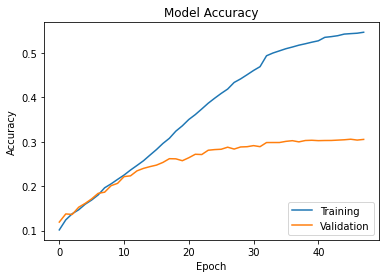

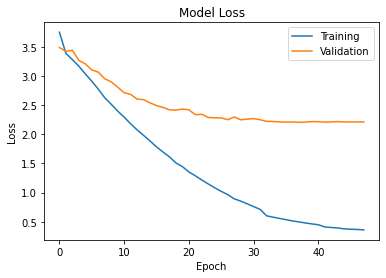

In [26]:
# list all data in history
# print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [27]:
# # Loading the saved model -- to be used in passing the inputs and layer configuration 
# # from the trained model into the inference models
# model_inference = Model([encoder_input, decoder_input], decoder_output, name = "Inference_Model")
# model_inference.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# model_inference.load_weights('English - Dutch/NMT_seq2seq_no_Attention.h5')

In [28]:
# # Loading the saved model -- to be used in passing the inputs and layer configuration 
# # from the trained model into the inference models
model_inference = keras.models.load_model('English - Dutch/NMT_seq2seq_no_Attention.h5')

To create the Encoder and Decoder models by using the trained model

- Using **model_inference.input** to get the trained model's input configuration and,
- Using **model_inference.layers** to get the trained model's layers 


 

In [29]:
for index, desc in enumerate(model_inference.input):
  print(index,": ", desc)

0 :  KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name='Encoder_input'), name='Encoder_input', description="created by layer 'Encoder_input'")
1 :  KerasTensor(type_spec=TensorSpec(shape=(None, 11), dtype=tf.float32, name='Decoder_input'), name='Decoder_input', description="created by layer 'Decoder_input'")


In [30]:
for index, desc in enumerate(model_inference.layers):
  print(index,": ", desc)

0 :  <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd8c8ca4e50>
1 :  <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd8c8ca4a10>
2 :  <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fd8c8ca4590>
3 :  <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fd8c8c9cb10>
4 :  <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fd8c8c9ce50>
5 :  <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fd8c8d026d0>
6 :  <tensorflow.python.keras.layers.core.Dense object at 0x7fd8c8ca4610>


In [31]:
# Encoder Inference
# encoder_inference = Model(encoder_input, encoder_state, name = 'Encoder_Inference')
encoder_inference = Model(model_inference.input[0], model_inference.layers[4].output[1:], name = 'Encoder_Inference')
encoder_inference.summary()

Model: "Encoder_Inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 9)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 9, 300)            1349700   
_________________________________________________________________
lstm (LSTM)                  [(None, 1024), (None, 102 5427200   
Total params: 6,776,900
Trainable params: 6,776,900
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Decoder Inference
decoder_input_h = Input(shape=(latent_dim,), name = 'decoder_input_h')
decoder_input_c = Input(shape=(latent_dim,), name = 'decoder_input_c')
decoder_state_input = [decoder_input_h, decoder_input_c]


# WARNING:tensorflow:Model was constructed with shape (None, 30), but it was called on an input with incompatible shape (None, 1).
# decoder_input_inference = model_inference.input[1] #--- changing this line of code to below to remove the above warning
decoder_input_inference = Input(shape=(1,), name = 'Decoder_Input')

# decoder_embed_inference = Embedding(len_target_vocab, latent_dim, mask_zero=True)(decoder_input_inference)
decoder_embed_inference = model_inference.layers[3](decoder_input_inference)

# decoder_output_inference, state_h_inf, state_c_inf = LSTM(latent_dim, return_sequences = True, return_state = True)(decoder_embed_inference, initial_state = decoder_state_input)
decoder_output_inference, state_h_inf, state_c_inf = model_inference.layers[5](decoder_embed_inference, initial_state = decoder_state_input)

decoder_state_output = [state_h_inf, state_c_inf]

# decoder_output_final = decoder_dense(decoder_output_inference)
decoder_output_final = model_inference.layers[6](decoder_output_inference)


decoder_inference = Model([decoder_input_inference] + decoder_state_input,
                          [decoder_output_final] + decoder_state_output, name = 'Decoder_Inference')

decoder_inference.summary()

Model: "Decoder_Inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder_Input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             5821440     Decoder_Input[0][0]              
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    [(None, 1024)]       0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    [(None, 1024)]       0                                            
__________________________________________________________________________________

In [33]:
# Reverse Dictionary to convert integer back to the respective token
reverse_source_vocab_index = {index : token for token, index in source_vocab_index.items()}
reverse_target_vocab_index = {index : token for token, index in target_vocab_index.items()}

In [34]:
def decode_sequence(input_seq):
  # encode the input sequence to get the internal state vectors
  states_value = encoder_inference.predict(input_seq)
  
  # generate empty target sequence of length 1 with only the start character
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = target_vocab_index['<bof>']
  
  # output sequence loop
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_inference.predict([target_seq] + states_value)
    
    # sample a token and add the corresponding character to the decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_vocab_index[sampled_token_index]
        
    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_token == '<eos>' or len(decoded_sentence.split()) > max_seq_len_target):
      stop_condition = True
      break
      

    decoded_sentence += ' ' + sampled_token
      
    # update the target sequence (length 1).
    target_seq[0, 0] = sampled_token_index
    
    # update states
    states_value = [h, c]
    
  return decoded_sentence.strip()

Translating

Converting Test data into same format as required by NMT model

In [35]:
encoder_input_test   = np.zeros((len(X_test), max_seq_len_source), dtype='float32')

# One- hot encoding
for line_index, (source_indv_line, target_indv_line) in enumerate(zip(X_test, y_test)):
  for token_index, token in enumerate(source_indv_line.split()):
    encoder_input_test[line_index, token_index] = source_vocab_index[token]

print("Encoder_input_data shape: ", encoder_input_test.shape, "\nSentence: ", X_test[0], "\nsample: ", encoder_input_test[0])

Encoder_input_data shape:  (1000, 9) 
Sentence:  ken has arrived in kyoto 
sample:  [2155. 1803.  231. 1985. 2201.    0.    0.    0.    0.]


In [36]:
print('Translating sentences from Training Set','---'*30)
for seq_index in range(5):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('----')
  print('Source English\t\t:', X_train[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_train[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence) 

print('\nTranslating sentences from Testing Set','---'*30)

for seq_index in range(5,10):
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('----')
  print('Source English\t\t:', X_test[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_test[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence) 
  

Translating sentences from Training Set ------------------------------------------------------------------------------------------
----
Source English		: the foreigner didnt know japanese at all
Original Dutch		: de buitenlander kende helemaal geen japans
Translated Dutch	: de buitenlander kende helemaal geen japans
----
Source English		: threequarters of the work was finished
Original Dutch		: driekwart van het werk was gedaan
Translated Dutch	: driekwart van het werk was
----
Source English		: cows are eating grass in the meadow
Original Dutch		: koeien grazen in de wei
Translated Dutch	: koeien grazen in de wei
----
Source English		: hanako likes cake very much
Original Dutch		: hanako houdt erg van gebak
Translated Dutch	: hanako houdt erg van pizza
----
Source English		: i ordered two teas and three coffees
Original Dutch		: ik heb twee thees en drie koffies besteld
Translated Dutch	: ik heb twee thees en drie koffies

Translating sentences from Testing Set -----------------------

BLeU

In [37]:
#Importing Blue
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
smooth = SmoothingFunction().method4

corpus_reference = []
corpus_hypothesis = []

sentence_reference = []
sentence_hypothesis = []

corpus_score_cumulative_bleu_1 = 0
corpus_score_cumulative_bleu_2 = 0
corpus_score_cumulative_bleu_3 = 0
corpus_score_cumulative_bleu_4 = 0

sen_score_cumulative_bleu_1 = []
sen_score_cumulative_bleu_2 = []
sen_score_cumulative_bleu_3 = []
sen_score_cumulative_bleu_4 = []

#Generating Bleu Score
for line_index in range(len(X_test)):

  line_data = encoder_input_test[line_index: line_index + 1]
  translation = decode_sequence(line_data)
  
  corpus_reference.append([y_test[line_index].split()[1:-1]])
  corpus_hypothesis.append(translation.split())

  sentence_reference = y_test[line_index].split()[1:-1]
  sentence_hypothesis = translation.split()

  try:
    score1 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
  except:
    score1 = 0
  
  try:
    score2 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
  except:
    score2 = 0
  
  try:
    score3 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
  except:
    score3 = 0

  try:
    score4 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)
  except:
    score4 = 0

  
  sen_score_cumulative_bleu_1.append(score1)
  sen_score_cumulative_bleu_2.append(score2)
  sen_score_cumulative_bleu_3.append(score3)
  sen_score_cumulative_bleu_4.append(score4) 


corpus_score_cumulative_bleu_1 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_2 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_3 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_4 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)

sen_score_cumulative_bleu_1 = np.array(sen_score_cumulative_bleu_1)
sen_score_cumulative_bleu_2 = np.array(sen_score_cumulative_bleu_2)
sen_score_cumulative_bleu_3 = np.array(sen_score_cumulative_bleu_3)
sen_score_cumulative_bleu_4 = np.array(sen_score_cumulative_bleu_4)

print("CORPUS Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(corpus_score_cumulative_bleu_1, 6), "\t2-gram: ", round(corpus_score_cumulative_bleu_2, 6), \
      "\t3-gram: ", round(corpus_score_cumulative_bleu_3, 6), "\t4-gram: ", round(corpus_score_cumulative_bleu_4, 6))

print("\n\nSENTENCE Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(sen_score_cumulative_bleu_1.mean(), 6), "\t2-gram: ", round(sen_score_cumulative_bleu_2.mean(), 6), \
      "\t3-gram: ", round(sen_score_cumulative_bleu_3.mean(), 6), "\t4-gram: ", round(sen_score_cumulative_bleu_4.mean(), 6))
 

CORPUS Level Cumulative Bleu - Without Attention
1-gram:  0.450777 	2-gram:  0.3241 	3-gram:  0.241759 	4-gram:  0.171092


SENTENCE Level Cumulative Bleu - Without Attention
1-gram:  0.438013 	2-gram:  0.359505 	3-gram:  0.311926 	4-gram:  0.264504


# Section 4 Attention

---



**Task 5 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

In [38]:
# Defining Encoder Architecture , trainable = False
encoder_input    = Input(shape = (max_seq_len_source,), name = 'Encoder_input')
embedded_encoder = Embedding(len_source_vocab, embedding_shape, weights=[source_embedding])(encoder_input) #,  trainable=False
encoder_lstm = LSTM(latent_dim,  return_sequences=True, unroll=True)(embedded_encoder)
encoder_last = encoder_lstm[:,-1,:]

In [39]:
# Defining Decoder Architecture
decoder_input    = Input(shape = (max_seq_len_target,), name = 'Decoder_input')
embedded_decoder = Embedding(len_target_vocab, latent_dim)(decoder_input) #embedding_shape
decoder_lstm = LSTM(latent_dim, return_sequences=True, unroll=True)(embedded_decoder, initial_state = [encoder_last,encoder_last])

In [40]:
# Attendtion model
attention_dot = dot([decoder_lstm, encoder_lstm], axes=[2,2])
attention_activate = Activation('softmax', name='attention')(attention_dot)

context = dot([attention_activate, encoder_lstm], axes=[2,1])

decoder_combined_context = concatenate([context, decoder_lstm])

output_context = TimeDistributed(Dense(2048, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(len_target_vocab, activation="softmax"), name = 'Decoder_Dense')(output_context)


In [41]:
Attention_model = Model(inputs = [encoder_input, decoder_input], outputs = [output], name = 'NMT_Attention_model')
Attention_model.summary()

Model: "NMT_Attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 9, 300)       1349700     Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 11)]         0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 9, 1024)      5427200     embedding_2[0][0]                
________________________________________________________________________________

In [42]:
Attention_model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics=['accuracy'])

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')

# Fitting the model
model_history = Attention_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                                    batch_size = batch_size , epochs = epochs, validation_split=0.12,
                                    callbacks=[reduce_lr, early_stop])

Attention_model.save('English - Dutch/NMT_seq2seq_Attention.h5')

Epoch 1/100
20/20 [==============================] - 30s 1s/step - loss: 5.2118 - accuracy: 0.0495 - val_loss: 3.5956 - val_accuracy: 0.1136
Epoch 2/100
20/20 [==============================] - 26s 1s/step - loss: 3.4324 - accuracy: 0.1193 - val_loss: 3.3746 - val_accuracy: 0.1384
Epoch 3/100
20/20 [==============================] - 25s 1s/step - loss: 3.1767 - accuracy: 0.1452 - val_loss: 3.0420 - val_accuracy: 0.1586
Epoch 4/100
20/20 [==============================] - 25s 1s/step - loss: 2.7861 - accuracy: 0.1665 - val_loss: 2.8825 - val_accuracy: 0.1769
Epoch 5/100
20/20 [==============================] - 23s 1s/step - loss: 2.4503 - accuracy: 0.1942 - val_loss: 2.6062 - val_accuracy: 0.2213
Epoch 6/100
20/20 [==============================] - 23s 1s/step - loss: 2.1258 - accuracy: 0.2317 - val_loss: 2.5276 - val_accuracy: 0.2104
Epoch 7/100
20/20 [==============================] - 23s 1s/step - loss: 1.8246 - accuracy: 0.2610 - val_loss: 2.2437 - val_accuracy: 0.2642
Epoch 8/100
2

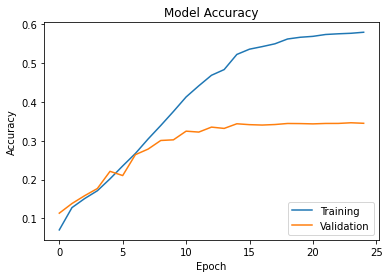

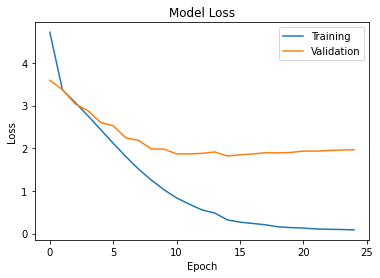

In [43]:
# list all data in history
# print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

In [44]:
Attention_model = keras.models.load_model('English - Dutch/NMT_seq2seq_Attention.h5')

In [45]:
def decode_sequence2(input_seq):
  
  # generate empty target sequence of length equal to target sentence with only the start character
  target_seq = np.zeros((1, max_seq_len_target))
  target_seq[0, 0] = target_vocab_index['<bof>']
  
  # output sequence loop
  stop_condition = False
  decoded_sentence = ''
  index = 1
  while not stop_condition:
    output_tokens = Attention_model.predict([input_seq, target_seq])
   
    # sample a token and add the corresponding character to the decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, index, :])
    sampled_token = reverse_target_vocab_index[sampled_token_index]
        
    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_token == '<eos>' or len(decoded_sentence.split()) > max_seq_len_target or index == 10): #
      stop_condition = True
      break
      
    decoded_sentence += ' ' + sampled_token
      
    # update the target sequence (length 1).
    target_seq[0, index] = sampled_token_index
    
    index+=1
    
  return decoded_sentence.strip()

In [46]:
print('Translating sentences from Training Set','---'*30)
for seq_index in range(5):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence2(input_seq)
  print('----')
  print('Source English\t\t:', X_train[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_train[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence) 

print('\nTranslating sentences from Testing Set','---'*30)

for seq_index in range(5,10):
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence2(input_seq)
  print('----')
  print('Source English\t\t:', X_test[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_test[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence) 
  

Translating sentences from Training Set ------------------------------------------------------------------------------------------
----
Source English		: the foreigner didnt know japanese at all
Original Dutch		: de buitenlander kende helemaal geen japans
Translated Dutch	: de kende helemaal geen
----
Source English		: threequarters of the work was finished
Original Dutch		: driekwart van het werk was gedaan
Translated Dutch	: de was hij met was
----
Source English		: cows are eating grass in the meadow
Original Dutch		: koeien grazen in de wei
Translated Dutch	: grazen in de van het
----
Source English		: hanako likes cake very much
Original Dutch		: hanako houdt erg van gebak
Translated Dutch	: houdt heel van
----
Source English		: i ordered two teas and three coffees
Original Dutch		: ik heb twee thees en drie koffies besteld
Translated Dutch	: twee en en twee

Translating sentences from Testing Set ------------------------------------------------------------------------------------

In [47]:
#Importing Blue
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
smooth = SmoothingFunction().method4

corpus_reference = []
corpus_hypothesis = []

sentence_reference = []
sentence_hypothesis = []

corpus_score_cumulative_bleu_1 = 0
corpus_score_cumulative_bleu_2 = 0
corpus_score_cumulative_bleu_3 = 0
corpus_score_cumulative_bleu_4 = 0

sen_score_cumulative_bleu_1 = []
sen_score_cumulative_bleu_2 = []
sen_score_cumulative_bleu_3 = []
sen_score_cumulative_bleu_4 = []

#Generating Bleu Score
for line_index in range(len(X_test)):

  line_data = encoder_input_test[line_index: line_index + 1]
  translation = decode_sequence2(line_data)
  
  corpus_reference.append([y_test[line_index].split()[1:-1]])
  corpus_hypothesis.append(translation.split())

  sentence_reference = y_test[line_index].split()[1:-1]
  sentence_hypothesis = translation.split()

  try:
    score1 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
  except:
    score1 = 0
  
  try:
    score2 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
  except:
    score2 = 0
  
  try:
    score3 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
  except:
    score3 = 0

  try:
    score4 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)
  except:
    score4 = 0

  
  sen_score_cumulative_bleu_1.append(score1)
  sen_score_cumulative_bleu_2.append(score2)
  sen_score_cumulative_bleu_3.append(score3)
  sen_score_cumulative_bleu_4.append(score4) 


corpus_score_cumulative_bleu_1 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_2 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_3 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_4 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)

sen_score_cumulative_bleu_1 = np.array(sen_score_cumulative_bleu_1)
sen_score_cumulative_bleu_2 = np.array(sen_score_cumulative_bleu_2)
sen_score_cumulative_bleu_3 = np.array(sen_score_cumulative_bleu_3)
sen_score_cumulative_bleu_4 = np.array(sen_score_cumulative_bleu_4)

print("CORPUS Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(corpus_score_cumulative_bleu_1, 6), "\t2-gram: ", round(corpus_score_cumulative_bleu_2, 6), \
      "\t3-gram: ", round(corpus_score_cumulative_bleu_3, 6), "\t4-gram: ", round(corpus_score_cumulative_bleu_4, 6))

print("\n\nSENTENCE Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(sen_score_cumulative_bleu_1.mean(), 6), "\t2-gram: ", round(sen_score_cumulative_bleu_2.mean(), 6), \
      "\t3-gram: ", round(sen_score_cumulative_bleu_3.mean(), 6), "\t4-gram: ", round(sen_score_cumulative_bleu_4.mean(), 6))
 

CORPUS Level Cumulative Bleu - Without Attention
1-gram:  0.304738 	2-gram:  0.132591 	3-gram:  0.053552 	4-gram:  0.020416


SENTENCE Level Cumulative Bleu - Without Attention
1-gram:  0.291962 	2-gram:  0.204157 	3-gram:  0.164793 	4-gram:  0.137758


References:
---

- https://www.tensorflow.org/guide/keras/masking_and_padding
- https://www.nltk.org/_modules/nltk/translate/bleu_score.html
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://stackoverflow.com/questions/53503389/how-to-set-parameters-in-keras-to-be-non-trainable
